In [1]:
import requests
import urllib3
from bs4 import BeautifulSoup as BS
import pandas as pd
import time
import os.path
%matplotlib inline
import bs4
import os
print(bs4.__version__)

4.6.3


In [0]:
company_listing = "http://www.nepalstock.com.np/company?_limit=500"

In [0]:
http = urllib3.PoolManager()
http.addheaders = [('User-agent', 'Mozilla/61.0')]
web_page = http.request('GET',company_listing)
soup = BS(web_page.data, 'html5lib')
table = soup.find('table')
company=[]
rows = [row.findAll('td') for row in table.findAll('tr')[1:-2]]
col = 0
notfirstrun = False
for row in rows:
    companydata =[]
    for data in row:
        if col == 5 and notfirstrun:
            companydata.append(data.a.get('href').split('/')[-1])
        else:
            companydata.append(data.text.strip())
        col += 1
    company.append(companydata)
    col =0
    notfirstrun = True

df = pd.DataFrame(company[1:],columns=company[0])
df.rename(columns={'Operations':'Symbol No'},inplace=True)
df.index.name = "SN"
df.drop(columns='',inplace=True)
df.drop(columns='S.N.',inplace=True)
df.to_json('CompanyList.json',orient='index')
print('There are %s Companies'%len(df.index))
df.head()
df.to_csv('CompanyList.csv', encoding='utf-8', index=False)

There are 220 Companies


In [0]:
# Getting Company Details
symbol = "NMB"
url = "http://www.nepalstock.com/company/"
try:
    req = requests.post(url, data={"stock_symbol":symbol}, verify=False)
except requests.exceptions.RequestException as e:
    print(e)
response = req.text
soup = BS(response, "lxml")
table = soup.find("table")
print ("Company: ",table.findAll("td")[0].string)
for row in table.findAll("tr")[4:]:
    col = row.findAll("td")
    print (col[0].string,": ",col[1].string)

Company:  NMB Bank Limited
Address :  Babarmahal
Email Address :  pramod.dahal@nmb.com.np
Website :  http://www.nmb.com.np
Last Traded Price (Rs.) :  335.00
Change (Rs.) and (%) :  4(1.21)
Total Listed Shares :  87,437,842.00
Paid Up Value (Rs.) :  100
Total Paid Up Value (Rs.) :  8,743,784,200.00
Closing Market Price (Rs.) :  335.00
Market Capitalization (Rs.) :  29,291,677,070.00


In [0]:
DailyFloorSheet="http://www.nepalstock.com.np/main/floorsheet/index/0/?_limit=5000"

http = urllib3.PoolManager()
http.addheaders = [('User-agent', 'Mozilla/61.0')]
web_page = http.request('GET',DailyFloorSheet)
soup = BS(web_page.data, 'html5lib')
table = soup.find('table')
FloorSheet=[]
rows = [row.findAll('td') for row in table.findAll('tr')[1:-2]]
for row in rows:
    FloorSheet.append([data.text.strip() for data in row])
FloorSheetdf = pd.DataFrame(FloorSheet[1:-1],columns=FloorSheet[0])
FloorSheetdf.head()

,S.N.,Contract No,Stock Symbol,Buyer Broker,Seller Broker,Quantity,Rate,Amount
0,1,2019040201007824,LBL,5,40,35,200,7000.00
1,2,2019040201007823,LBL,7,40,1000,201,201000.00
2,3,2019040201007822,LBL,34,40,965,201,193965.00
3,4,2019040201007821,LBL,58,40,1000,201,201000.00
4,5,2019040201007820,NBB,37,26,56,204,11424.00


In [0]:
df['date'] = pd.to_datetime(FloorSheetdf['Contract No'],format='%Y%m%d%H%M%f').dt.date

In [0]:
def CompanyStocksTransactions(SymbolNo,startDate, endDate):
    url="http://www.nepalstock.com.np/company/transactions/%s/0/?startDate=%s&endDate=%s&_limit=9000000"%(SymbolNo,startDate, endDate)
    #print("Connecting to %s "%url)
    http = urllib3.PoolManager()
    http.addheaders = [('User-agent', 'Mozilla/61.0')]
    web_page = http.request('GET',url)
    #print("Adding to DataFrame")
    soup = BS(web_page.data, 'html5lib')
    table = soup.find('table')
    FloorSheet=[]
    rows = [row.findAll('td') for row in table.findAll('tr')[1:-2]]
    for row in rows:
      FloorSheet.append([data.text.strip() for data in row])
    if(len(FloorSheet) != 0):
      FloorSheetdf = pd.DataFrame(FloorSheet[1:],columns=FloorSheet[0])
      FloorSheetdf['Date']=pd.to_datetime(FloorSheetdf['Contract No'], format='%Y%m%d%H%M%f', errors='ignore')
      return (1, FloorSheetdf)
    else:
      return (0, None)

In [0]:
try:
  os.mkdir('nepse_data')
except FileExistsError:
  
  for year in range(20):
    startDate = 2000 + year
    startDate = str(startDate) + '-1-1'

    endDate = 2000 + year
    endDate = str(endDate) + '-12-31'

    count = 0
    print("From year %s to %s "%(startDate, endDate))
    #dir_name = startDate + " to " + endDate
    #os.mkdir(dir_name)
    #print("Directory created...")
    time1 = time.time()
    for symbol in list(df['Symbol No']):
        #print("Stock No: %s\nTime: %s"%(symbol,time.ctime()))
        #if(os.path.isfile() 
        filename = "nepse_data/NEPSE%s.csv"%symbol
        count +=1
        """if os.path.isfile(filename):
            print("Stock No: %s Data Already Downloaded"%symbol)
        else:
        """
        success, dftest=CompanyStocksTransactions(symbol,startDate, endDate)
        if(success != 0):
          dftest.to_csv(filename, mode='a', header=False, encoding='utf-8', index=False)
          print("%s of %s completed in %s \n"%(count,len(df['Symbol No'])))
            #else:
              #print('Error....')
    print("Completed this year in %s . \n"%(time.time() - time1))

From year 2000-1-1 to 2000-12-31 


TypeError: ignored

In [0]:
import shutil
shutil.make_archive('nepse_data', 'zip', 'nepse_data')

'/content/nepse_data.zip'

In [0]:
Stock = 'EBL'
symbol = "%d"%df[df['Stock Symbol']==Stock]['Symbol No']
print(symbol)
dfNepse=pd.read_csv("nepse_data/NEPSE%s.csv"%symbol, header = None)
#dfNepse.columns = ["S.N.","Contract No", "Stock Symbol", "Buyer Broker", "Seller Broker", "Quantity", "Rate", "Amount", "Junk"]
#dfNepse.drop('Junk', 1, inplace = True)
print(len(dfNepse))
#dfNepse.drop_duplicates(subset = ['Contract No'], keep = False)
print(len(dfNepse))
dfNepse.head()

137
139806
139806


,0,1,2,3,4,5,6,7,8
0,1,126563,EBL,14,24,10,1200,12000.0,126563
1,2,126562,EBL,14,24,10,1200,12000.0,126562
2,3,126561,EBL,14,10,10,1200,12000.0,126561
3,4,126477,EBL,32,32,50,1240,62000.0,126477
4,5,126476,EBL,1,1,20,1205,24100.0,126476


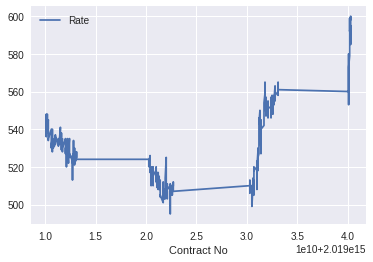

In [0]:
# plot
# Need to convert Contract Number to Date-time
Stock = 'EBL'
symbol = "%d"%df[df['Stock Symbol']==Stock]['Symbol No']

dfNepse=pd.read_csv("nepse_data/NEPSE%s.csv"%symbol, header = None)
dfNepse.columns = ["S.N.","Contract No", "Stock Symbol", "Buyer Broker", "Seller Broker", "Quantity", "Rate", "Amount", "Junk"]
#dfNepse.drop('Junk', 1, inplace = True)
dfNepse.drop_duplicates(subset = ['Contract No'], keep = False)

dfNepse.sort_values('Contract No')
startfrom=2019010101000000
#print(pd.to_datetime(startfrom[0:8], format='%Y%m%d', errors='ignore'))
#dfNepse=dfNepse[dfNepse['Contract No']>startfrom]
dfNepse = dfNepse[dfNepse['Contract No'].between(startfrom, 2019040301005230, inclusive = False)]
dfNepse.plot(x='Contract No', y = 'Rate')

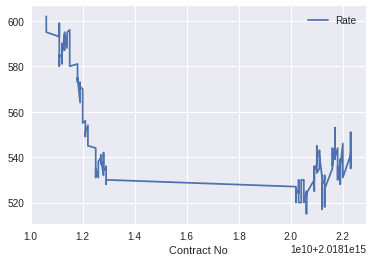

In [0]:
# plot
# Need to convert Contract Number to Date-time
Stock = 'EBL'
symbol = "%d"%df[df['Stock Symbol']==Stock]['Symbol No']

dfNepse=pd.read_csv("NEPSE%s.csv"%symbol)
dfNepse.sort_values('Contract No')
startfrom=2001001016341249
dfNepse = dfNepse[dfNepse['Contract No'].between(startfrom, 2018122301008660, inclusive = False)]
dfNepse.plot(x='Contract No', y = 'Rate')

In [0]:
dfNepse.describe()

In [4]:
symbol = "EBL"
url = "http://nepalstock.com/marketdepth/"

try:
    req = requests.post(url, data={"stock_symbol":symbol}, verify=False)
except requests.exceptions.RequestException as e:
    print(e)
response = req.text
soup = BS(response, "lxml")
tables = soup.findAll("table")
#print(tables)
table = [i for i in tables]
#print(table)
row = [find_row.find("tr") for find_row in table]
print(row[1])

for table in tables:  
  for row in table.findAll("tr"):
      col = row.findAll("td")
      #print('--\n', col)
      
     # print(col[0].string,": ",col[1].string)

<tr>
<td><table border="1" class="depthIndex" width="100%">
<tr>
<td><label class="livePrice">
                        596.00</label><br/>
<span class="indicator greenIndicator"></span>
<span class="green">4.00  
                        0.68%</span>
</td>
<td><label>Pr. Close </label><br/>592.00</td>
<td><label>Open </label><br/>591.00</td>
<td><label>High </label><br/>602.00</td>
<td><label>Low </label><br/>591.00</td>
<td><label>Close</label><br/>

                        596.00</td>
</tr>
</table></td>
</tr>


In [5]:
#print(tables)
table = [i for i in tables]
#print(table)
row = [find_row.find("tr") for find_row in table]
col = row[1].findAll("td")
label = col[0].findAll("label")
print(col[0])
print(label.string)

<td><table border="1" class="depthIndex" width="100%">
<tr>
<td><label class="livePrice">
                        596.00</label><br/>
<span class="indicator greenIndicator"></span>
<span class="green">4.00  
                        0.68%</span>
</td>
<td><label>Pr. Close </label><br/>592.00</td>
<td><label>Open </label><br/>591.00</td>
<td><label>High </label><br/>602.00</td>
<td><label>Low </label><br/>591.00</td>
<td><label>Close</label><br/>

                        596.00</td>
</tr>
</table></td>


AttributeError: ignored